## Training Data Cleaning
Download and load the dataset. There are some issues with the training split of the data that would stop it being
used to train a classifier. Report all issues and how you fixed them.

Let's import the dataset and print the training split.

In [ ]:
# Install necessary tools
!wget -O dataset.zip https://tinyurl.com/tadarchives
!unzip dataset.zip -d dataset
import json
import pandas as pd

# Define the path
file_path = "dataset/dataset.json"

# Load the dataset
with open(file_path, "r") as f:
    museums = json.load(f)

# Print  the length and the 10 first examples of the training dataset
print('--------------------------------------')
print('The length of the training split is: ' + str(len(museums['train'])))

print('--------------------------------------')
print(json.dumps(museums['train'][:10], indent=2))

--2025-03-15 19:50:56--  https://tinyurl.com/tadarchives
Resolving tinyurl.com (tinyurl.com)... 104.18.111.161, 104.17.112.233, 2606:4700::6812:6fa1, ...
Connecting to tinyurl.com (tinyurl.com)|104.18.111.161|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gla-my.sharepoint.com/:u:/g/personal/jake_lever_glasgow_ac_uk/EcsUMcfLirhOkodUHhTLfQEBlLKRv2nI0skIGhZqa5KokQ?download=1 [following]
--2025-03-15 19:50:56--  https://gla-my.sharepoint.com/:u:/g/personal/jake_lever_glasgow_ac_uk/EcsUMcfLirhOkodUHhTLfQEBlLKRv2nI0skIGhZqa5KokQ?download=1
Resolving gla-my.sharepoint.com (gla-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to gla-my.sharepoint.com (gla-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/jake_lever_glasgow_ac_uk/Documents/Teaching/tad_coursework_archives.zip?ga=1 [following]
--2025-03-15 19:50:57--  https://gla-my.shar

 We can see that there are 3 subcategories for each post. Let's further explore the structure of our training, validation and test datasets.

In [ ]:
# Function to find all unique keys from the dataset (for training, valitaiton and test)
def get_all_keys(dataset):
    keys_count = {}
    for record in dataset:
        for key in record.keys():
            keys_count[key] = keys_count.get(key, 0) + 1
    return keys_count

# Checking unique fields in each dataset split
for split in ['train', 'val', 'test']:
    print(f"Field distribution in {split}:")
    print(get_all_keys(museums[split]))  # Count occurrences of each field
    print("-" * 50)

Field distribution in train:
{'id': 155, 'labl': 39, 'description': 41, 'content': 56, 'text': 58, 'key': 60, 'label': 56}
--------------------------------------------------
Field distribution in val:
{'id': 50, 'label': 50, 'content': 50}
--------------------------------------------------
Field distribution in test:
{'id': 50, 'label': 50, 'content': 50}
--------------------------------------------------


It is clear that the validation and test datasets follow the same structure of 3 subcategories ('id', 'label', 'content'), while the training dataset has its subcategories disorganized. I will further explore my training dataset to ultimately convert it to the relative structure of the validation and training datasets.
My next step is to randomly print 2 examples for each of these subcategories for the training dataset, to understand what they represent.


In [ ]:
import random

# Function to sample random records for each key in train dataset
def sample_train_records(dataset, num_samples=2):
    for key in ["id", "labl", "description", "content", "text", "key", "label"]:
        print(f"\nRandom samples for key: {key}\n")

        # Filter records that contain the specific key
        matching_records = [record for record in dataset if key in record and record[key]]

        # Randomly sample from matching records
        if matching_records:
            samples = random.sample(matching_records, min(num_samples, len(matching_records)))
            for sample in samples:
                print(json.dumps(sample, indent=2))
        else:
            print(f"No records found for key: {key}")

        print("-" * 60)

# Run sampling function on the train dataset
sample_train_records(museums["train"])



Random samples for key: id

{
  "id": "3ed4e89a-15e0-acda-b40d-ab69bf501b9b",
  "label": 2,
  "text": "Letter to Daniel Otto. Contains a letter from Hill which reads; 'Dear Otto, In reply to your letter I send you a note showing that you were my boy when I was in the Cameroon's and Nigeria. Yours Truly (Sd) ARTHUR W. HILL Director'."
}
{
  "id": "b7a9494b-2738-ec6a-e5b3-523d2cb27b74",
  "content": "James Couling, Drummer in the Berkshire Militia, brought Samuel Rowland before me as a deserter from HM Squirrel. He swore that Rowland told him that he was deserter. Samuel Rowland said he never belonged to the ship, only as a servant to a Lieutenant who died and when his Master died he left the ship. Rowland is now in gaol. Signed Henry Harding Morgo.",
  "key": 0
}
------------------------------------------------------------

Random samples for key: labl

{
  "id": "a7e10af0-dda1-6788-1d44-6c26f97da428",
  "labl": 3,
  "text": "Indentures of Lease and Release. Being the Assignment by sur

It is clear that 'label', 'labl' and 'key' represent the same thing, and I will convert all these to 'label'. The same applies for 'content', 'description' and 'text', which I will convert to 'content'. Also, some of the examples indicate that the subcategories don't follow the same sequence always, which should be ('id' > 'label' > 'content'). I will take care of this as well.

In [ ]:
# Function to standardize column names and order
def standardize_records(dataset):
    standardized_data = []

    for record in dataset:
        standardized_record = {}

        # Keep the existing ID
        standardized_record["id"] = record.get("id", None)

        # Extract label (preserve existing valid labels)
        if "label" in record and record["label"] is not None:
            standardized_record["label"] = record["label"]
        elif "labl" in record and record["labl"] is not None:
            standardized_record["label"] = record["labl"]
        elif "key" in record and record["key"] is not None:
            standardized_record["label"] = record["key"]
        else:
            standardized_record["label"] = None  # Only set None if no label exists

        # Extract content
        standardized_record["content"] = (
            record.get("content") or record.get("description") or record.get("text") or None
        )

        standardized_data.append(standardized_record)

    return standardized_data


# Apply the standardization to the training split
museums["train"] = standardize_records(museums["train"])

# Check a sample after standardization
print(f"Field distribution in train split:")
print(get_all_keys(museums["train"]))  # Count occurrences of each field
print("-" * 50)
print(json.dumps(museums["train"][:5], indent=2))  # Print first 3 records of train set


Field distribution in train split:
{'id': 155, 'label': 155, 'content': 155}
--------------------------------------------------
[
  {
    "id": "08838524-6d11-729c-39d8-fa4d712b7476",
    "label": 1,
    "content": "Exhaust steam pipe protector piece fitted below ashpan door Copy drawing EO V2.40 Darlington; B2 Darlington 1943 2 cylinders (B17 rebuild deleted); Darlington; Gorton B1 1948 Classes A2, A3, A4, C2, D1, D2, D3, K2, K3, K4, P2, V2, V4 B1, B2"
  },
  {
    "id": "467eb98e-1866-708e-03cd-9ab9f8a7f4e5",
    "label": "oyal Botanic Gardens, Kew",
    "content": "This journal seems to have been kept parallel with RM 1/17 (FKW/1/17), covering Kingdon-Ward's time teaching at the RAF Jungle School up to the end of 1944. In early 1945, not having been offered any work, Kingdon Ward took a trip on the Brahmaputra. In June, he is offered a job on a tea plantation until 30 Nov when he is told to report to Calcutta."
  },
  {
    "id": "7ab43067-856c-5cee-8574-ac59a24de44b",
    "label": 

There are some missing letters in some of the labels, so I am going to fix this using TF-IDF and Cosine Similarity.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Define correct labels
correct_labels = [
    "National Maritime Museum",
    "National Railway Museum",
    "Royal Botanic Gardens, Kew",
    "Royal College of Physicians of London",
    "Shakespeare Birthplace Trust"
]

# Vectorize correct labels
vectorizer = TfidfVectorizer()
correct_label_vectors = vectorizer.fit_transform(correct_labels)

# Function to fix labels using TF-IDF + Cosine Similarity
def fix_labels_tfidf(dataset):
    for record in dataset:
        if record["label"] and isinstance(record["label"], str):
            # Transform the corrupted label into a vector
            label_vector = vectorizer.transform([record["label"]])

            # Compute cosine similarity with correct labels
            similarities = cosine_similarity(label_vector, correct_label_vectors)

            # Get the best match
            best_match_index = np.argmax(similarities)
            best_match = correct_labels[best_match_index]
            confidence = similarities[0, best_match_index]

            # Replace if confidence is high
            if confidence > 0.80:
                record["label"] = best_match
            else:
                print(f"⚠ Warning: Low confidence fix for '{record['label']}' -> '{best_match}' (Score: {confidence:.2f})")

    return dataset

# Apply label fixing
museums["train"] = fix_labels_tfidf(museums["train"])
# museums["val"] = fix_labels_tfidf(museums["val"])
# museums["test"] = fix_labels_tfidf(museums["test"])

# Print some corrected labels
print(json.dumps(museums["train"][:5], indent=2))

[
  {
    "id": "08838524-6d11-729c-39d8-fa4d712b7476",
    "label": 1,
    "content": "Exhaust steam pipe protector piece fitted below ashpan door Copy drawing EO V2.40 Darlington; B2 Darlington 1943 2 cylinders (B17 rebuild deleted); Darlington; Gorton B1 1948 Classes A2, A3, A4, C2, D1, D2, D3, K2, K3, K4, P2, V2, V4 B1, B2"
  },
  {
    "id": "467eb98e-1866-708e-03cd-9ab9f8a7f4e5",
    "label": "Royal Botanic Gardens, Kew",
    "content": "This journal seems to have been kept parallel with RM 1/17 (FKW/1/17), covering Kingdon-Ward's time teaching at the RAF Jungle School up to the end of 1944. In early 1945, not having been offered any work, Kingdon Ward took a trip on the Brahmaputra. In June, he is offered a job on a tea plantation until 30 Nov when he is told to report to Calcutta."
  },
  {
    "id": "7ab43067-856c-5cee-8574-ac59a24de44b",
    "label": "Royal Botanic Gardens, Kew",
    "content": null
  },
  {
    "id": "b78f8473-e487-b3cb-be65-4f854d97228b",
    "label": "Roya

It seems that this problem is solved. Now, I am going to check if there are any missing values in my train split, before proceeding with the analysis.

In [ ]:
# Count missing values in the training dataset
missing_id = sum(1 for record in museums["train"] if record.get("id") is None)
missing_label = sum(1 for record in museums["train"] if record.get("label") is None)
missing_content = sum(1 for record in museums["train"] if record.get("content") is None)

# Print missing value counts
print("Missing Values in Training Dataset:")
print(f"Missing ID: {missing_id}")
print(f"Missing Label: {missing_label}")
print(f"Missing Content: {missing_content}")

Missing Values in Training Dataset:
Missing ID: 0
Missing Label: 0
Missing Content: 2


Now I will check for any inconsistencies in the 'content' subcategory and fix them if necessary.

In [ ]:
# Print and Remove Missing (None) `content`
def remove_missing_content(dataset):
    missing_records = [record for record in dataset if record.get("content") is None]

    # Print number of missing records
    print(f"\nTotal Missing (None) `content`: {len(missing_records)}")

    # Print records before deleting
    for record in missing_records:
        print(json.dumps(record, indent=2))
        print("-" * 60)

    # Remove records with missing content
    cleaned_dataset = [record for record in dataset if record.get("content") is not None]
    print(f"\nRemoved {len(missing_records)} records with missing content.")

    return cleaned_dataset

# Print and Remove Invalid `content` (not a string)
def remove_invalid_content(dataset):
    invalid_records = [record for record in dataset if not isinstance(record.get("content"), str)]

    # Print number of invalid records
    print(f"\n⚠ Total Invalid (Non-String) `content`: {len(invalid_records)}")

    # Print records before deleting
    for record in invalid_records:
        print(json.dumps(record, indent=2))
        print("-" * 60)

    # Remove records with invalid content
    cleaned_dataset = [record for record in dataset if isinstance(record.get("content"), str)]
    print(f"\nRemoved {len(invalid_records)} records with invalid content.")

    return cleaned_dataset

# Apply Both Steps to Training Data
museums["train"] = remove_missing_content(museums["train"])  # Remove missing content
museums["train"] = remove_invalid_content(museums["train"])  # Remove invalid content


Total Missing (None) `content`: 2
{
  "id": "7ab43067-856c-5cee-8574-ac59a24de44b",
  "label": "Royal Botanic Gardens, Kew",
  "content": null
}
------------------------------------------------------------
{
  "id": "95a0d569-602a-5bdc-06ca-62eb08302d3d",
  "label": "National Railway Museum",
  "content": null
}
------------------------------------------------------------

Removed 2 records with missing content.

⚠ Total Invalid (Non-String) `content`: 3
{
  "id": "7148fce2-2315-1826-2615-05abd9b0b806",
  "label": "National Railway Museum",
  "content": 258157
}
------------------------------------------------------------
{
  "id": "aa985a46-605f-2be7-12ba-9204d8d240e4",
  "label": "Shakespeare Birthplace Trust",
  "content": 829308
}
------------------------------------------------------------
{
  "id": "246aeb01-6686-57ab-9f4e-3a15f01446e5",
  "label": "Royal College of Physicians of London",
  "content": 535970
}
------------------------------------------------------------

Removed

Now I am going to convert my labels to their corresponding indices. I will do this for all the splits.


In [ ]:
# Define the Label-to-Index Mapping
label_mapping = {
    "National Maritime Museum": 0,
    "National Railway Museum": 1,
    "Royal Botanic Gardens, Kew": 2,
    "Royal College of Physicians of London": 3,
    "Shakespeare Birthplace Trust": 4
}

# Convert String Labels to Integer Indices
def convert_labels_to_indices(dataset):
    for record in dataset:
        if isinstance(record["label"], str) and record["label"] in label_mapping:
            record["label"] = label_mapping[record["label"]]
        elif record["label"] is None:
            print(f"⚠ Warning: Missing label for record ID {record['id']}")

    return dataset

# Apply the conversion to all datasets
museums["train"] = convert_labels_to_indices(museums["train"])
museums["val"] = convert_labels_to_indices(museums["val"])
museums["test"] = convert_labels_to_indices(museums["test"])

# Print a few converted records
print("\n📄 Sample of Training Data with Converted Labels:")
print(json.dumps(museums["train"][:5], indent=2))

# Count missing values in the training dataset
missing_id = sum(1 for record in museums["train"] if record.get("id") is None)
missing_label = sum(1 for record in museums["train"] if record.get("label") is None)
missing_content = sum(1 for record in museums["train"] if record.get("content") is None)

# Print missing value counts
print("Missing Values in Training Dataset:")
print(f"Missing ID: {missing_id}")
print(f"Missing Label: {missing_label}")
print(f"Missing Content: {missing_content}")
print('--------------------------------------')
print('The length of the training split is: ' + str(len(museums['train'])))


📄 Sample of Training Data with Converted Labels:
[
  {
    "id": "08838524-6d11-729c-39d8-fa4d712b7476",
    "label": 1,
    "content": "Exhaust steam pipe protector piece fitted below ashpan door Copy drawing EO V2.40 Darlington; B2 Darlington 1943 2 cylinders (B17 rebuild deleted); Darlington; Gorton B1 1948 Classes A2, A3, A4, C2, D1, D2, D3, K2, K3, K4, P2, V2, V4 B1, B2"
  },
  {
    "id": "467eb98e-1866-708e-03cd-9ab9f8a7f4e5",
    "label": 2,
    "content": "This journal seems to have been kept parallel with RM 1/17 (FKW/1/17), covering Kingdon-Ward's time teaching at the RAF Jungle School up to the end of 1944. In early 1945, not having been offered any work, Kingdon Ward took a trip on the Brahmaputra. In June, he is offered a job on a tea plantation until 30 Nov when he is told to report to Calcutta."
  },
  {
    "id": "b78f8473-e487-b3cb-be65-4f854d97228b",
    "label": 2,
    "content": "'Remainder Correspondence of the Bibliographical Index' Five letters to and from N D 

We can see that now we have no missing values, and our train split is ready for use.

##Exploration##
Once the training set has been fixed, report the following:
*  The sample counts for the training, validation and test sets
*    The percentage splits for training, validation and test sets
*   The minimum and maximum length (in characters) of the texts. Report separately for the training, validation
and test sets
*   The most frequent five tokens in each class (after tokenizing with *text_pipeline_spacy* from Lab 2)

In [ ]:
from collections import Counter
import spacy

# Extract dataset splits
train_set = museums['train']
val_set = museums['val']
test_set = museums['test']

# Sample counts per dataset
train_count = len(train_set)
val_count = len(val_set)
test_count = len(test_set)
total_count = train_count + val_count + test_count

print(f"Training samples: {train_count}")
print(f"Validation samples: {val_count}")
print(f"Test samples: {test_count}")

# Percentage splits per dataset
train_pct = (train_count / total_count) * 100
val_pct = (val_count / total_count) * 100
test_pct = (test_count / total_count) * 100

print(f"Training: {train_pct:.2f}%")
print(f"Validation: {val_pct:.2f}%")
print(f"Test: {test_pct:.2f}%")

# Compute min/max text lengths per dataset
def text_lengths(dataset, key='content'):
    lengths = [len(item[key]) for item in dataset if key in item]
    return min(lengths), max(lengths)

train_min, train_max = text_lengths(train_set)
val_min, val_max = text_lengths(val_set)
test_min, test_max = text_lengths(test_set)

print(f"Train Text Lengths: Min={train_min}, Max={train_max}")
print(f"Validation Text Lengths: Min={val_min}, Max={val_max}")
print(f"Test Text Lengths: Min={test_min}, Max={test_max}")

# Load spaCy for tokenization
nlp = spacy.load("en_core_web_sm")

# Use text_pipeline_spacy from Lab 2
def text_pipeline_spacy(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space:
            tokens.append(t.lemma_.lower())
    return tokens

# Get most frequent tokens per class
class_counts = {i: Counter() for i in range(5)}
for item in train_set:
    label = item['label']
    tokens = text_pipeline_spacy(item['content'])  # Using lab function now
    class_counts[label].update(tokens)

# Display top 5 tokens per class
for label, counter in class_counts.items():
    print(f"Class {label}: {counter.most_common(5)}")

Training samples: 150
Validation samples: 50
Test samples: 50
Training: 60.00%
Validation: 20.00%
Test: 20.00%
Train Text Lengths: Min=163, Max=4263
Validation Text Lengths: Min=154, Max=2794
Test Text Lengths: Min=167, Max=3479
Class 0: [('john', 16), ('sir', 11), ('henry', 10), ('enclosure', 10), ('james', 9)]
Class 1: [('2000', 144), ('7200', 144), ('756', 143), ('gb', 142), ('collection', 31)]
Class 2: [('letter', 30), ('include', 15), ('paper', 14), ('list', 12), ('contain', 11)]
Class 3: [('seal', 25), ('common', 21), ('mr.', 17), ('college', 17), ('fellow', 17)]
Class 4: [('mr.', 18), ('work', 16), ('bill', 15), ('account', 14), ('letter', 14)]


##Prompting with a large language model
Calculate the accuracy, macro precision, macro recall and macro F1 for each prompt template and comment on the result.
Consider any invalid output from the LLM as predicting a sixth hypothetical class.

In [ ]:
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Ensure the dataset is correctly loaded
def get_ground_truth_labels(museums):
    return [record["label"] for record in museums["train"]]

# Function to load predictions safely
def load_predictions(file_path):
    if not os.path.exists(file_path):
        print(f"⚠ Warning: File not found: {file_path}. Skipping this prompt.")
        return None
    with open(file_path, "r") as f:
        predictions_data = json.load(f)
    return [entry.get("next_token") for entry in predictions_data]

# Paths to the uploaded prediction files
prompt_files = {
    "Prompt 1": "dataset/llm_prompt_template_1.json",
    "Prompt 2": "dataset/llm_prompt_template_2.json",
    "Prompt 3": "dataset/llm_prompt_template_3.json"
}

# Load ground truth labels
ground_truth_labels = get_ground_truth_labels(museums)

# Ensure labels are correctly formatted
ground_truth_labels = [int(label) if isinstance(label, (int, str)) and str(label).isdigit() else 5 for label in ground_truth_labels]

# Store results
results = []

# Process each prompt template
for prompt_name, file_path in prompt_files.items():
    predictions = load_predictions(file_path)
    if predictions is None:
        continue  # Skip missing files

    # Process predictions: convert to integers and handle invalid cases
    processed_predictions = [
        int(pred) if isinstance(pred, (int, str)) and str(pred).isdigit() else 5
        for pred in predictions
    ]

    # Ensure predictions and ground truth are the same length
    min_len = min(len(processed_predictions), len(ground_truth_labels))
    processed_predictions = processed_predictions[:min_len]
    gt_labels = ground_truth_labels[:min_len]

    # Compute metrics
    accuracy = accuracy_score(gt_labels, processed_predictions)
    precision = precision_score(gt_labels, processed_predictions, average="macro", zero_division=0)
    recall = recall_score(gt_labels, processed_predictions, average="macro", zero_division=0)
    f1 = f1_score(gt_labels, processed_predictions, average="macro", zero_division=0)

    # Store results
    results.append([prompt_name, accuracy, precision, recall, f1])

# Convert results to DataFrame for visualization
results_df = pd.DataFrame(results, columns=["Prompt Template", "Accuracy", "Macro Precision", "Macro Recall", "Macro F1"])

# Display results
print(results_df)

  Prompt Template  Accuracy  Macro Precision  Macro Recall  Macro F1
0        Prompt 1  0.000000         0.000000      0.000000  0.000000
1        Prompt 2  0.760000         0.788615      0.754925  0.743436
2        Prompt 3  0.706667         0.674268      0.582762  0.584574


Prompt 1 has 0 values for all metrics, probably because all its examples were invalid and assigned to the sixth class. Prompt 2 has the highest performance everywhere. The 76% Accuracy indicates a good overall classification and the High Macro Precision shows that this prompt is confident enough. The 75% Macro Recall shows that Prompt 2 captures a big proportion of the true positives, while the 74% relatively high F1 score can confirm a strong balance between precision and recall. On the other hand, Prompt 3 was outperformed by Prompt 2, slightly in Accuracy and Macro Precision. Its Macro F1 of 58% indicates that it's less balanced than Prompt 2. These results indicate that probably Prompt 3 is less structured than Prompt 2.
Now I will print the 3 first examples for each prompt, to mostly understand the nature of Prompt 1:

In [ ]:
# Print first 3 examples from each prompt file
for prompt_name, file_path in prompt_files.items():
    predictions = load_predictions(file_path)

    print('--------------------------------------')
    print(f'First 3 examples from {prompt_name}:')
    print(json.dumps(predictions[:3], indent=2))

--------------------------------------
First 3 examples from Prompt 1:
[
  "Based",
  "Based",
  "Based"
]
--------------------------------------
First 3 examples from Prompt 2:
[
  "1",
  "2",
  "3"
]
--------------------------------------
First 3 examples from Prompt 3:
[
  "1",
  "2",
  "1"
]


It is clear now why Prompt 1 has values of 0 on all metrics. Its labels are not integers but strings, compared to the other prompts. In my dataset before I converted all lables to integers, and for this all the examples from Prompt 1 were considered invalid and assigned to the sixth class.

##Fine-tune a transformer
Fine-tune a ‘bert-base-uncased’ transformer model on the model using the training set. You should use an
AutoModelForSequenceClassification and the HuggingFace trainer. Use 8 epochs, a learning_rate of 5e-5 and a batch
size of 8.
Evaluate on the validation set. Report the per-class precision, recall and F1 score as well as the accuracy, macro
precision, macro recall and macro F1 score. Don’t be surprised with poor performance.


In [ ]:
# To check if GPU is being used
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

GPU Available: True
GPU Name: Tesla T4


In [ ]:
!pip install datasets
import torch
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import set_seed

SEED = 111

# Ensure all randomness sources are controlled
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Hugging Face transformers seed setup
set_seed(SEED)

# Load the dataset
train_texts = [record["content"] for record in museums["train"]]
train_labels = [record["label"] for record in museums["train"]]
val_texts = [record["content"] for record in museums["val"]]
val_labels = [record["label"] for record in museums["val"]]

# Convert dataset to Hugging Face Dataset format
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

# Load tokenizer
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=512)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Load Model
num_labels = len(set(train_labels))  # Number of unique labels
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

# Define Evaluation Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro", zero_division=0)

    # Modified to unpack 4 values (precision, recall, f1, support)
    per_class_metrics = {
        f"class_{i}": {"precision": p, "recall": r, "f1": f}
        for i, (p, r, f, _) in enumerate(zip(
            *precision_recall_fscore_support(labels, predictions, average=None, zero_division=0)
        ))
    }

    return {
        "accuracy": accuracy,
        "macro_precision": precision,
        "macro_recall": recall,
        "macro_f1": f1,
        "per_class_metrics": per_class_metrics
    }

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="model",  # Creates a unique folder to prevent overwriting older models
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,  # As required in the coursework
    learning_rate=5e-5,  # As required
    report_to="none"  # Suppress logging
)

# Prepare Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train Model
trainer.train()

# Evaluate Model
eval_results = trainer.evaluate()

# Extract and Print Results
overall_metrics = {
    "Accuracy": eval_results["eval_accuracy"],
    "Macro Precision": eval_results["eval_macro_precision"],
    "Macro Recall": eval_results["eval_macro_recall"],
    "Macro F1-score": eval_results["eval_macro_f1"]
}

per_class_metrics = pd.DataFrame.from_dict(eval_results["eval_per_class_metrics"], orient="index")

# Print Overall Metrics
print("\n======= Overall Metrics =======")
for metric, value in overall_metrics.items():
    print(f"{metric}: {value:.3f}")

# Print Per-Class Metrics in Table Format
print("\n======= Metrics for each Class =======")
print(per_class_metrics.to_string(float_format="%.3f"))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.3 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-13-9a68285c1d41>:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Per Class Metrics
1,No log,1.614726,0.340000,0.227636,0.363636,0.260606,"{'class_0': {'precision': 0.32, 'recall': 1.0, 'f1': 0.48484848484848486}, 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_2': {'precision': 0.8181818181818182, 'recall': 0.8181818181818182, 'f1': 0.8181818181818182}, 'class_3': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_4': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}"
2,No log,1.981259,0.220000,0.157143,0.200000,0.176000,"{'class_0': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_2': {'precision': 0.7857142857142857, 'recall': 1.0, 'f1': 0.88}, 'class_3': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_4': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}"
3,No log,2.435967,0.240000,0.208333,0.225000,0.216304,"{'class_0': {'precision': 0.125, 'recall': 0.125, 'f1': 0.125}, 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_2': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1': 0.9565217391304348}, 'class_3': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_4': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}"
4,No log,3.043426,0.200000,0.181818,0.181818,0.181818,"{'class_0': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_2': {'precision': 0.9090909090909091, 'recall': 0.9090909090909091, 'f1': 0.9090909090909091}, 'class_3': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_4': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}"
5,No log,3.940183,0.200000,0.181818,0.181818,0.181818,"{'class_0': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_2': {'precision': 0.9090909090909091, 'recall': 0.9090909090909091, 'f1': 0.9090909090909091}, 'class_3': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_4': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}"
6,No log,4.204368,0.200000,0.166667,0.181818,0.173913,"{'class_0': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_2': {'precision': 0.8333333333333334, 'recall': 0.9090909090909091, 'f1': 0.8695652173913043}, 'class_3': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_4': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}"
7,No log,4.436380,0.200000,0.166667,0.181818,0.173913,"{'class_0': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_2': {'precision': 0.8333333333333334, 'recall': 0.9090909090909091, 'f1': 0.8695652173913043}, 'class_3': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_4': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}"
8,No log,4.498043,0.200000,0.166667,0.181818,0.173913,"{'class_0': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_2': {'precision': 0.8333333333333334, 'recall': 0.9090909090909091, 'f1': 0.8695652173913043}, 'class_3': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_4': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}"



======= Overall Metrics =======
Accuracy: 0.200
Macro Precision: 0.167
Macro Recall: 0.182
Macro F1-score: 0.174

======= Metrics for each Class =======
         precision  recall    f1
class_0      0.000   0.000 0.000
class_1      0.000   0.000 0.000
class_2      0.833   0.909 0.870
class_3      0.000   0.000 0.000
class_4      0.000   0.000 0.000


The performance is very bad. The 20% accuracy indicates that the classifier predicts correctly 1 out of 5 times. Probably there is something wrong with the validation dataset.
Also, only class 2 presented good results, while all the other classes had values of 0 on their metrics.

##A problem with the validation set
There is an issue with the validation set which causes poor performance. Provide the confusion matrix. Describe the
problem, how you identified it and how you fixed it.


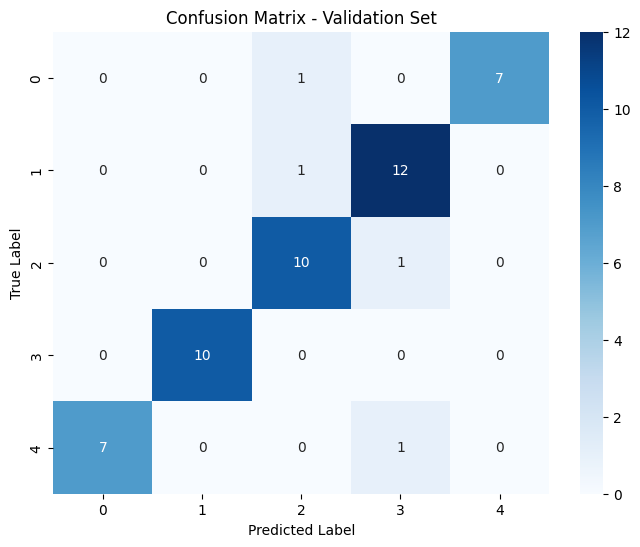

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get model predictions for validation dataset
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = [record["label"] for record in museums["val"]]

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(set(true_labels)), yticklabels=sorted(set(true_labels)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Validation Set")
plt.show()

There is a clear problem of label mismatching on the validation dataset. Labels are shifted or were assigned incorrectly. The matches should be on the main diagonal, but the opposite is happening. For example, the true label of class 0 is almost entirely predicted as class 4. For class 2, which is exactly in the middle of the confusion matrix, nothing changed in the prediction because it keeps the same position even if the diagonal changes direction. That's why class 2 is the only one that presented high accuracy before.
For this, I am going to remap the labels to their correct ones, since it seems that they were classified to the opposite direction:

Corrected Validation Set Label Distribution: Counter({3: 13, 2: 11, 1: 10, 0: 8, 4: 8})


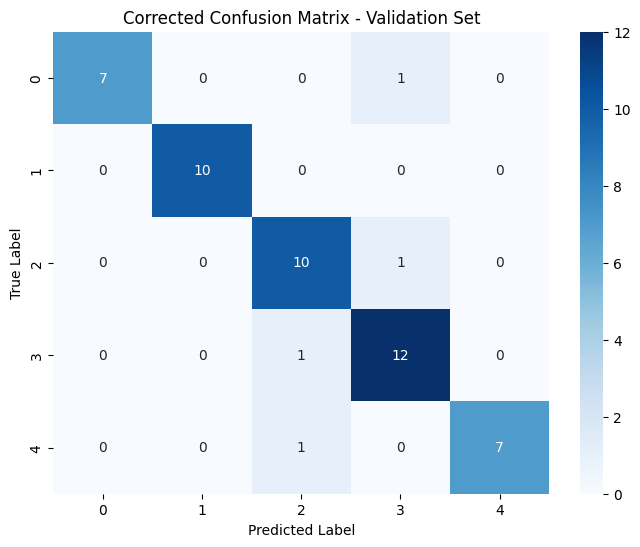

Corrected Validation Set Label Distribution: Counter({3: 13, 2: 11, 1: 10, 0: 8, 4: 8})


In [ ]:
label_mapping = {0: 4, 1: 3, 2: 2, 3: 1, 4: 0}

# Apply label remapping (keeping the format as a list)
true_labels_fixed = [label_mapping[label] for label in true_labels]

# Recompute the confusion matrix with corrected labels
cm_fixed = confusion_matrix(true_labels_fixed, predicted_labels)

# Print to verify the label distribution
from collections import Counter
print("Corrected Validation Set Label Distribution:", Counter(true_labels_fixed))

# Plot the corrected confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_fixed, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(set(true_labels_fixed)),
            yticklabels=sorted(set(true_labels_fixed)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Corrected Confusion Matrix - Validation Set")
plt.show()

# Print to verify the label distribution
from collections import Counter
print("Corrected Validation Set Label Distribution:", Counter(true_labels_fixed))

Now the validation test has the correct structure and it will perform better.

##Hyperparameter tuning
Train and evaluate several fine-tuned transformer models using the corrected training and validation sets. Try the
four base models listed below. Use 8 epochs, a learning_rate of 5e-5 and a batch size of 8. Base models to try: 'bert-base-uncased','roberta-base','distilbert-base-uncased', and
'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract'
This time, we want the best model found during the training process for each base model and to save it for the final
analysis. For example, if the model after 3 epochs is the best performing on the validation set (by macro-F1), we want
to keep that. You should investigate the load_best_model_at_end parameter for the Trainer (which does require
other parameters).
Evaluate each fine-tuned model on the validation set. Report the per-class precision, recall and F1 score as well as the
accuracy, macro precision, macro recall and macro F1 score. Comment on the performance of each model.


In [ ]:
import os
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
import pandas as pd

SEED = 111

# Fix Python, NumPy, PyTorch, and CUDA randomness
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

base_models = [
    'bert-base-uncased',
    'roberta-base',
    'distilbert-base-uncased',
    'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract'
]

# Corrected label mapping
label_mapping = {0: 4, 1: 3, 2: 2, 3: 1, 4: 0}
val_labels_fixed = [label_mapping[label] for label in val_labels]

# Re-create the original datasets with the 'text' column
train_texts = [record["content"] for record in museums["train"]]
train_labels = [record["label"] for record in museums["train"]]
val_texts = [record["content"] for record in museums["val"]]

train_dataset_original = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset_original = Dataset.from_dict({"text": val_texts, "label": val_labels_fixed})

# Dictionaries to store best models and scores
best_model_paths = {}  # To store the best checkpoint directory per model
best_model_scores = {}  # To store the best macro-F1 score per model

for model_name in base_models:
    print(f"Training {model_name}...")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    # Tokenize datasets - Using the original datasets with the 'text' column
    train_dataset = train_dataset_original.map(
        lambda examples: tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512),
        batched=True
    )
    val_dataset = val_dataset_original.map(
        lambda examples: tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512),
        batched=True
    )

    # Define output directory
    output_dir = f"model_{model_name}"

    # Define training arguments with load_best_model_at_end
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,  # Keep only the best checkpoint
        load_best_model_at_end=True,  # Load best model
        metric_for_best_model="eval_macro_f1",  # Evaluate based on macro F1
        greater_is_better=True,  # Higher F1 is better
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=8,
        learning_rate=5e-5,
        report_to="none"
    )

    # Create Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

    # Save the best model (ensured by load_best_model_at_end)
    best_model_path = os.path.join(output_dir, "best_model")
    trainer.save_model(best_model_path)

    # Evaluate the best model
    eval_results = trainer.evaluate()
    print(f"Evaluation results for {model_name}:")
    print(eval_results)

    # Store the best model path and score in variables (not CSV)
    best_model_paths[model_name] = best_model_path
    best_model_scores[model_name] = eval_results["eval_macro_f1"]

    # Print overall and per-class metrics
    overall_metrics = {
        "Accuracy": eval_results["eval_accuracy"],
        "Macro Precision": eval_results["eval_macro_precision"],
        "Macro Recall": eval_results["eval_macro_recall"],
        "Macro F1-score": eval_results["eval_macro_f1"]
    }

    per_class_metrics = pd.DataFrame.from_dict(eval_results["eval_per_class_metrics"], orient="index")

    # Print Overall Metrics
    print("\n======= Overall Metrics =======")
    for metric, value in overall_metrics.items():
        print(f"{metric}: {value:.3f}")

    # Print Per-Class Metrics in Table Format
    print("\n======= Metrics for each Class =======")
    print(per_class_metrics.to_string(float_format="%.3f"))

# Print Summary of Best Models (No CSV, just stored in variables)
print("\n====== Best Models Summary ======")
for model, path in best_model_paths.items():
    print(f"Model: {model} | Best Path: {path} | Best Macro-F1: {best_model_scores[model]:.3f}")



Training bert-base-uncased...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-4df30e583d25>:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Per Class Metrics
1,No log,1.117549,0.600000,0.609455,0.609790,0.526082,"{'class_0': {'precision': 0.32, 'recall': 1.0, 'f1': 0.48484848484848486}, 'class_1': {'precision': 0.9090909090909091, 'recall': 1.0, 'f1': 0.9523809523809523}, 'class_2': {'precision': 0.8181818181818182, 'recall': 0.8181818181818182, 'f1': 0.8181818181818182}, 'class_3': {'precision': 1.0, 'recall': 0.23076923076923078, 'f1': 0.375}, 'class_4': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}"
2,No log,0.700698,0.900000,0.926374,0.894231,0.903326,"{'class_0': {'precision': 1.0, 'recall': 0.875, 'f1': 0.9333333333333333}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.7857142857142857, 'recall': 1.0, 'f1': 0.88}, 'class_3': {'precision': 0.8461538461538461, 'recall': 0.8461538461538461, 'f1': 0.8461538461538461}, 'class_4': {'precision': 1.0, 'recall': 0.75, 'f1': 0.8571428571428571}}"
3,No log,0.384544,0.920000,0.929762,0.909615,0.915511,"{'class_0': {'precision': 0.875, 'recall': 0.875, 'f1': 0.875}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1': 0.9565217391304348}, 'class_3': {'precision': 0.8571428571428571, 'recall': 0.9230769230769231, 'f1': 0.8888888888888888}, 'class_4': {'precision': 1.0, 'recall': 0.75, 'f1': 0.8571428571428571}}"
4,No log,0.231681,0.920000,0.941818,0.916434,0.926580,"{'class_0': {'precision': 1.0, 'recall': 0.875, 'f1': 0.9333333333333333}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.9090909090909091, 'recall': 0.9090909090909091, 'f1': 0.9090909090909091}, 'class_3': {'precision': 0.8, 'recall': 0.9230769230769231, 'f1': 0.8571428571428571}, 'class_4': {'precision': 1.0, 'recall': 0.875, 'f1': 0.9333333333333333}}"
5,No log,0.155288,0.940000,0.953247,0.941434,0.946263,"{'class_0': {'precision': 1.0, 'recall': 0.875, 'f1': 0.9333333333333333}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.9090909090909091, 'recall': 0.9090909090909091, 'f1': 0.9090909090909091}, 'class_3': {'precision': 0.8571428571428571, 'recall': 0.9230769230769231, 'f1': 0.8888888888888888}, 'class_4': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}}"
6,No log,0.164891,0.920000,0.938095,0.916434,0.925024,"{'class_0': {'precision': 1.0, 'recall': 0.875, 'f1': 0.9333333333333333}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.8333333333333334, 'recall': 0.9090909090909091, 'f1': 0.8695652173913043}, 'class_3': {'precision': 0.8571428571428571, 'recall': 0.9230769230769231, 'f1': 0.8888888888888888}, 'class_4': {'precision': 1.0, 'recall': 0.875, 'f1': 0.9333333333333333}}"
7,No log,0.172592,0.920000,0.938095,0.916434,0.925024,"{'class_0': {'precision': 1.0, 'recall': 0.875, 'f1': 0.9333333333333333}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.8333333333333334, 'recall': 0.9090909090909091, 'f1': 0.8695652173913043}, 'class_3': {'precision': 0.8571428571428571, 'recall': 0.9230769230769231, 'f1': 0.8888888888888888}, 'class_4': {'precision': 1.0, 'recall': 0.875, 'f1': 0.9333333333333333}}"
8,No log,0.172477,0.920000,0.938095,0.916434,0.925024,"{'class_0': {'precision': 1.0, 'recall': 0.875, 'f1': 0.9333333333333333}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.8333333333333334, 'recall': 0.9090909090909091, 'f1': 0.8695652173913043}, 'class_3': {'precision': 0.8571428571428571, 'recall': 0.9230769230769231, 'f1': 0.8888888888888888}, 'class_4': {'precision': 1.0, 'recall': 0.875, 'f1': 0.9333333333333333}}"


Evaluation results for bert-base-uncased:
{'eval_loss': 0.15528768301010132, 'eval_accuracy': 0.94, 'eval_macro_precision': 0.9532467532467532, 'eval_macro_recall': 0.9414335664335665, 'eval_macro_f1': 0.9462626262626262, 'eval_per_class_metrics': {'class_0': {'precision': 1.0, 'recall': 0.875, 'f1': 0.9333333333333333}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.9090909090909091, 'recall': 0.9090909090909091, 'f1': 0.9090909090909091}, 'class_3': {'precision': 0.8571428571428571, 'recall': 0.9230769230769231, 'f1': 0.8888888888888888}, 'class_4': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}}, 'eval_runtime': 1.53, 'eval_samples_per_second': 32.68, 'eval_steps_per_second': 4.575, 'epoch': 8.0}

======= Overall Metrics =======
Accuracy: 0.940
Macro Precision: 0.953
Macro Recall: 0.941
Macro F1-score: 0.946

======= Metrics for each Class =======
         precision  recall    f1
class_0      1.000   0.875 0.933
class_1      1.000   1.000 1.000
cla

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-4df30e583d25>:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Per Class Metrics
1,No log,1.432471,0.360000,0.197089,0.400000,0.245024,"{'class_0': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_1': {'precision': 0.7692307692307693, 'recall': 1.0, 'f1': 0.8695652173913043}, 'class_2': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_3': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_4': {'precision': 0.21621621621621623, 'recall': 1.0, 'f1': 0.35555555555555557}}"
2,No log,0.950661,0.620000,0.597647,0.627972,0.532143,"{'class_0': {'precision': 0.4, 'recall': 1.0, 'f1': 0.5714285714285714}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.5882352941176471, 'recall': 0.9090909090909091, 'f1': 0.7142857142857143}, 'class_3': {'precision': 1.0, 'recall': 0.23076923076923078, 'f1': 0.375}, 'class_4': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}"
3,No log,0.608403,0.820000,0.898810,0.802273,0.816830,"{'class_0': {'precision': 0.875, 'recall': 0.875, 'f1': 0.875}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 1.0, 'recall': 0.6363636363636364, 'f1': 0.7777777777777778}, 'class_3': {'precision': 0.6190476190476191, 'recall': 1.0, 'f1': 0.7647058823529411}, 'class_4': {'precision': 1.0, 'recall': 0.5, 'f1': 0.6666666666666666}}"
4,No log,0.400563,0.920000,0.925714,0.906818,0.910053,"{'class_0': {'precision': 0.7, 'recall': 0.875, 'f1': 0.7777777777777778}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 1.0, 'recall': 0.9090909090909091, 'f1': 0.9523809523809523}, 'class_3': {'precision': 0.9285714285714286, 'recall': 1.0, 'f1': 0.9629629629629629}, 'class_4': {'precision': 1.0, 'recall': 0.75, 'f1': 0.8571428571428571}}"
5,No log,0.502409,0.840000,0.901429,0.806818,0.817143,"{'class_0': {'precision': 0.8571428571428571, 'recall': 0.75, 'f1': 0.8}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 1.0, 'recall': 0.9090909090909091, 'f1': 0.9523809523809523}, 'class_3': {'precision': 0.65, 'recall': 1.0, 'f1': 0.7878787878787878}, 'class_4': {'precision': 1.0, 'recall': 0.375, 'f1': 0.5454545454545454}}"
6,No log,0.591274,0.840000,0.886842,0.806818,0.812067,"{'class_0': {'precision': 0.75, 'recall': 0.75, 'f1': 0.75}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 1.0, 'recall': 0.9090909090909091, 'f1': 0.9523809523809523}, 'class_3': {'precision': 0.6842105263157895, 'recall': 1.0, 'f1': 0.8125}, 'class_4': {'precision': 1.0, 'recall': 0.375, 'f1': 0.5454545454545454}}"
7,No log,0.506715,0.880000,0.891818,0.866434,0.874675,"{'class_0': {'precision': 0.75, 'recall': 0.75, 'f1': 0.75}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.9090909090909091, 'recall': 0.9090909090909091, 'f1': 0.9090909090909091}, 'class_3': {'precision': 0.8, 'recall': 0.9230769230769231, 'f1': 0.8571428571428571}, 'class_4': {'precision': 1.0, 'recall': 0.75, 'f1': 0.8571428571428571}}"
8,No log,0.509621,0.900000,0.908802,0.891434,0.895730,"{'class_0': {'precision': 0.7777777777777778, 'recall': 0.875, 'f1': 0.8235294117647058}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.9090909090909091, 'recall': 0.9090909090909091, 'f1': 0.9090909090909091}, 'class_3': {'precision': 0.8571428571428571, 'recall': 0.9230769230769231, 'f1': 0.8888888888888888}, 'class_4': {'precision': 1.0, 'recall': 0.75, 'f1': 0.8571428571428571}}"


Evaluation results for roberta-base:
{'eval_loss': 0.4005626440048218, 'eval_accuracy': 0.92, 'eval_macro_precision': 0.9257142857142858, 'eval_macro_recall': 0.9068181818181819, 'eval_macro_f1': 0.91005291005291, 'eval_per_class_metrics': {'class_0': {'precision': 0.7, 'recall': 0.875, 'f1': 0.7777777777777778}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 1.0, 'recall': 0.9090909090909091, 'f1': 0.9523809523809523}, 'class_3': {'precision': 0.9285714285714286, 'recall': 1.0, 'f1': 0.9629629629629629}, 'class_4': {'precision': 1.0, 'recall': 0.75, 'f1': 0.8571428571428571}}, 'eval_runtime': 1.3976, 'eval_samples_per_second': 35.776, 'eval_steps_per_second': 5.009, 'epoch': 8.0}

======= Overall Metrics =======
Accuracy: 0.920
Macro Precision: 0.926
Macro Recall: 0.907
Macro F1-score: 0.910

======= Metrics for each Class =======
         precision  recall    f1
class_0      0.700   0.875 0.778
class_1      1.000   1.000 1.000
class_2      1.000   0

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-4df30e583d25>:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Per Class Metrics
1,No log,1.224218,0.620000,0.767018,0.620804,0.589501,"{'class_0': {'precision': 0.3684210526315789, 'recall': 0.875, 'f1': 0.5185185185185185}, 'class_1': {'precision': 0.6666666666666666, 'recall': 1.0, 'f1': 0.8}, 'class_2': {'precision': 1.0, 'recall': 0.36363636363636365, 'f1': 0.5333333333333333}, 'class_3': {'precision': 0.8, 'recall': 0.6153846153846154, 'f1': 0.6956521739130435}, 'class_4': {'precision': 1.0, 'recall': 0.25, 'f1': 0.4}}"
2,No log,0.757120,0.800000,0.829524,0.785664,0.788728,"{'class_0': {'precision': 0.6, 'recall': 0.75, 'f1': 0.6666666666666666}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.8333333333333334, 'recall': 0.9090909090909091, 'f1': 0.8695652173913043}, 'class_3': {'precision': 0.7142857142857143, 'recall': 0.7692307692307693, 'f1': 0.7407407407407407}, 'class_4': {'precision': 1.0, 'recall': 0.5, 'f1': 0.6666666666666666}}"
3,No log,0.429635,0.920000,0.938462,0.919231,0.923993,"{'class_0': {'precision': 1.0, 'recall': 0.75, 'f1': 0.8571428571428571}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.8461538461538461, 'recall': 1.0, 'f1': 0.9166666666666666}, 'class_3': {'precision': 0.8461538461538461, 'recall': 0.8461538461538461, 'f1': 0.8461538461538461}, 'class_4': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}}"
4,No log,0.328490,0.920000,0.943333,0.909615,0.920828,"{'class_0': {'precision': 1.0, 'recall': 0.75, 'f1': 0.8571428571428571}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1': 0.9565217391304348}, 'class_3': {'precision': 0.8, 'recall': 0.9230769230769231, 'f1': 0.8571428571428571}, 'class_4': {'precision': 1.0, 'recall': 0.875, 'f1': 0.9333333333333333}}"
5,No log,0.256661,0.940000,0.942949,0.934615,0.937586,"{'class_0': {'precision': 0.875, 'recall': 0.875, 'f1': 0.875}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1': 0.9565217391304348}, 'class_3': {'precision': 0.9230769230769231, 'recall': 0.9230769230769231, 'f1': 0.9230769230769231}, 'class_4': {'precision': 1.0, 'recall': 0.875, 'f1': 0.9333333333333333}}"
6,No log,0.227749,0.940000,0.952564,0.944231,0.946000,"{'class_0': {'precision': 1.0, 'recall': 0.875, 'f1': 0.9333333333333333}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.8461538461538461, 'recall': 1.0, 'f1': 0.9166666666666666}, 'class_3': {'precision': 0.9166666666666666, 'recall': 0.8461538461538461, 'f1': 0.88}, 'class_4': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}}"
7,No log,0.222437,0.960000,0.967949,0.959615,0.962586,"{'class_0': {'precision': 1.0, 'recall': 0.875, 'f1': 0.9333333333333333}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1': 0.9565217391304348}, 'class_3': {'precision': 0.9230769230769231, 'recall': 0.9230769230769231, 'f1': 0.9230769230769231}, 'class_4': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}}"
8,No log,0.220338,0.960000,0.967949,0.959615,0.962586,"{'class_0': {'precision': 1.0, 'recall': 0.875, 'f1': 0.9333333333333333}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1': 0.9565217391304348}, 'class_3': {'precision': 0.9230769230769231, 'recall': 0.9230769230769231, 'f1': 0.9230769230769231}, 'class_4': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}}"


Evaluation results for distilbert-base-uncased:
{'eval_loss': 0.22243747115135193, 'eval_accuracy': 0.96, 'eval_macro_precision': 0.9679487179487178, 'eval_macro_recall': 0.9596153846153846, 'eval_macro_f1': 0.9625863991081383, 'eval_per_class_metrics': {'class_0': {'precision': 1.0, 'recall': 0.875, 'f1': 0.9333333333333333}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1': 0.9565217391304348}, 'class_3': {'precision': 0.9230769230769231, 'recall': 0.9230769230769231, 'f1': 0.9230769230769231}, 'class_4': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}}, 'eval_runtime': 0.7903, 'eval_samples_per_second': 63.267, 'eval_steps_per_second': 8.857, 'epoch': 8.0}

======= Overall Metrics =======
Accuracy: 0.960
Macro Precision: 0.968
Macro Recall: 0.960
Macro F1-score: 0.963

======= Metrics for each Class =======
         precision  recall    f1
class_0      1.000   0.875 0.933
class_1      1.000   1.000 1.000
class_2  

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-4df30e583d25>:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Per Class Metrics
1,No log,1.290194,0.500000,0.478022,0.546154,0.431710,"{'class_0': {'precision': 0.46153846153846156, 'recall': 0.75, 'f1': 0.5714285714285714}, 'class_1': {'precision': 0.5, 'recall': 1.0, 'f1': 0.6666666666666666}, 'class_2': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'class_3': {'precision': 1.0, 'recall': 0.23076923076923078, 'f1': 0.375}, 'class_4': {'precision': 0.42857142857142855, 'recall': 0.75, 'f1': 0.5454545454545454}}"
2,No log,0.758285,0.780000,0.792757,0.787937,0.776792,"{'class_0': {'precision': 0.8571428571428571, 'recall': 0.75, 'f1': 0.8}, 'class_1': {'precision': 0.9090909090909091, 'recall': 1.0, 'f1': 0.9523809523809523}, 'class_2': {'precision': 0.75, 'recall': 0.5454545454545454, 'f1': 0.631578947368421}, 'class_3': {'precision': 0.9090909090909091, 'recall': 0.7692307692307693, 'f1': 0.8333333333333334}, 'class_4': {'precision': 0.5384615384615384, 'recall': 0.875, 'f1': 0.6666666666666666}}"
3,No log,0.579440,0.820000,0.811328,0.807867,0.807760,"{'class_0': {'precision': 0.8571428571428571, 'recall': 0.75, 'f1': 0.8}, 'class_1': {'precision': 0.9090909090909091, 'recall': 1.0, 'f1': 0.9523809523809523}, 'class_2': {'precision': 0.8181818181818182, 'recall': 0.8181818181818182, 'f1': 0.8181818181818182}, 'class_3': {'precision': 0.9166666666666666, 'recall': 0.8461538461538461, 'f1': 0.88}, 'class_4': {'precision': 0.5555555555555556, 'recall': 0.625, 'f1': 0.5882352941176471}}"
4,No log,0.623062,0.780000,0.753247,0.748252,0.739182,"{'class_0': {'precision': 0.8571428571428571, 'recall': 0.75, 'f1': 0.8}, 'class_1': {'precision': 0.9090909090909091, 'recall': 1.0, 'f1': 0.9523809523809523}, 'class_2': {'precision': 0.75, 'recall': 0.8181818181818182, 'f1': 0.782608695652174}, 'class_3': {'precision': 0.75, 'recall': 0.9230769230769231, 'f1': 0.8275862068965517}, 'class_4': {'precision': 0.5, 'recall': 0.25, 'f1': 0.3333333333333333}}"
5,No log,0.678441,0.840000,0.830037,0.816434,0.818730,"{'class_0': {'precision': 0.8571428571428571, 'recall': 0.75, 'f1': 0.8}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.7692307692307693, 'recall': 0.9090909090909091, 'f1': 0.8333333333333334}, 'class_3': {'precision': 0.8571428571428571, 'recall': 0.9230769230769231, 'f1': 0.8888888888888888}, 'class_4': {'precision': 0.6666666666666666, 'recall': 0.5, 'f1': 0.5714285714285714}}"
6,No log,0.675571,0.860000,0.860275,0.841434,0.842521,"{'class_0': {'precision': 0.875, 'recall': 0.875, 'f1': 0.875}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.7692307692307693, 'recall': 0.9090909090909091, 'f1': 0.8333333333333334}, 'class_3': {'precision': 0.8571428571428571, 'recall': 0.9230769230769231, 'f1': 0.8888888888888888}, 'class_4': {'precision': 0.8, 'recall': 0.5, 'f1': 0.6153846153846154}}"
7,No log,0.712105,0.860000,0.854017,0.841434,0.839065,"{'class_0': {'precision': 0.7777777777777778, 'recall': 0.875, 'f1': 0.8235294117647058}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.7692307692307693, 'recall': 0.9090909090909091, 'f1': 0.8333333333333334}, 'class_3': {'precision': 0.9230769230769231, 'recall': 0.9230769230769231, 'f1': 0.9230769230769231}, 'class_4': {'precision': 0.8, 'recall': 0.5, 'f1': 0.6153846153846154}}"
8,No log,0.716519,0.840000,0.821795,0.816434,0.815568,"{'class_0': {'precision': 0.75, 'recall': 0.75, 'f1': 0.75}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.7692307692307693, 'recall': 0.9090909090909091, 'f1': 0.8333333333333334}, 'class_3': {'precision': 0.9230769230769231, 'recall': 0.9230769230769231, 'f1': 0.9230769230769231}, 'class_4': {'precision': 0.6666666666666666, 'recall': 0.5, 'f1': 0.5714285714285714}}"


Evaluation results for microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract:
{'eval_loss': 0.6755712032318115, 'eval_accuracy': 0.86, 'eval_macro_precision': 0.8602747252747254, 'eval_macro_recall': 0.8414335664335665, 'eval_macro_f1': 0.8425213675213676, 'eval_per_class_metrics': {'class_0': {'precision': 0.875, 'recall': 0.875, 'f1': 0.875}, 'class_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'class_2': {'precision': 0.7692307692307693, 'recall': 0.9090909090909091, 'f1': 0.8333333333333334}, 'class_3': {'precision': 0.8571428571428571, 'recall': 0.9230769230769231, 'f1': 0.8888888888888888}, 'class_4': {'precision': 0.8, 'recall': 0.5, 'f1': 0.6153846153846154}}, 'eval_runtime': 1.5215, 'eval_samples_per_second': 32.862, 'eval_steps_per_second': 4.601, 'epoch': 8.0}

======= Overall Metrics =======
Accuracy: 0.860
Macro Precision: 0.860
Macro Recall: 0.841
Macro F1-score: 0.843

======= Metrics for each Class =======
         precision  recall    f1
class_0      0.875   0.875 0

##Final evaluation and deployment
Load the best model (based on macro-F1 on the validation set) that was saved in the previous question using a
‘text-classification’ pipeline. Evaluate the best of the four fine-tuned models on the testing set.
State which model you used and report the per-class precision, recall and F1 score as well as the accuracy, macro
precision, macro recall and macro F1 score. Comment on the performance and discuss whether the quality is high
enough to be deployed for the client.

In [ ]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from datasets import Dataset
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

# Load the best model based on macro-F1 on the validation set
best_model_name = max(best_model_scores, key=best_model_scores.get)
best_model_path = best_model_paths[best_model_name]

print(f"Loading best model: {best_model_name} from {best_model_path}\n")

# Load tokenizer and model
classifier = pipeline("text-classification", model=best_model_path, tokenizer=best_model_path)

# Load the test dataset
test_texts = [record["content"] for record in museums["test"]]
test_labels = [record["label"] for record in museums["test"]]

# Make predictions
predictions = classifier(test_texts, truncation=True)
predicted_labels = [int(pred["label"].split("_")[-1]) for pred in predictions]

# Generate classification report (excluding 'support')
report_dict = classification_report(test_labels, predicted_labels, target_names=[
    "National Maritime Museum", "National Railway Museum", "Royal Botanic Gardens, Kew",
    "Royal College of Physicians of London", "Shakespeare Birthplace Trust"
], digits=4, output_dict=True, zero_division=0)  # zero_division handles potential errors

# Remove 'support' from the report dictionary
for key in report_dict:
    if isinstance(report_dict[key], dict) and 'support' in report_dict[key]:
        del report_dict[key]['support']

# Extracting values for macro precision, recall, and F1-score
macro_precision = report_dict["macro avg"]["precision"]
macro_recall = report_dict["macro avg"]["recall"]
macro_f1 = report_dict["macro avg"]["f1-score"]

# Extracting accuracy
accuracy = report_dict["accuracy"]

# Extracting per-class metrics (excluding 'support')
per_class_metrics = pd.DataFrame(report_dict).transpose().drop('support', axis=1, errors='ignore')

# Print results
print("Final Model Evaluation on Test Set:")
print(f"Best Model: {best_model_name}\n")  # State the model used
print(per_class_metrics.to_string(float_format="%.4f"))

print("\n====== Overall Metrics ======")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}\n")

Loading best model: distilbert-base-uncased from model_distilbert-base-uncased/best_model



Device set to use cuda:0


Final Model Evaluation on Test Set:
Best Model: distilbert-base-uncased

                                       precision  recall  f1-score
National Maritime Museum                  1.0000  0.8462    0.9167
National Railway Museum                   0.8750  1.0000    0.9333
Royal Botanic Gardens, Kew                0.8462  1.0000    0.9167
Royal College of Physicians of London     0.8571  1.0000    0.9231
Shakespeare Birthplace Trust              0.9091  0.7692    0.8333
accuracy                                  0.9000  0.9000    0.9000
macro avg                                 0.8975  0.9231    0.9046
weighted avg                              0.9079  0.9000    0.8981

====== Overall Metrics ======
Accuracy: 0.9000
Macro Precision: 0.8975
Macro Recall: 0.9231
Macro F1-score: 0.9046

